In [1]:
import pandas as pd
import numpy as np

proc_tracks.ipynb


In [79]:
def load_track_txt(track_txt_path) -> pd.DataFrame:
    # track_txt_path = "../experiments/rocket/nov_28/t1/VID_20241129_011318_2.txt"
    f = open(track_txt_path, "r")
    # f.readline()
    l1 = f.readline()[:-2]
    l2 = f.readline()[:-2] # x = -y
    track_names = [i for i in l1.split("\t") if i != ""]
    columns = l2.split("\t")
    print(columns, track_names)

    cn_per_track = int( (len(columns) - 1) / len(track_names) )

    for i in range(1, len(columns)):
        columns[i] = track_names[(i-1)//cn_per_track] + "__" + columns[i]


    data = np.array([[float('nan') if j == "" else float(j.strip())  for j in i[:-1].split("\t")]for i in f.readlines()])

    df = pd.DataFrame(data, columns=columns)
    df = df.dropna(axis=0)
    print(df)
    
    return (df["t"].to_numpy(), df["mass A__x"].to_numpy())

In [85]:
def split_into_clusters(time, x):
    # Calculate time differences between consecutive measurements
    time_differences = np.diff(time)
    
    # Threshold for splitting tracks: set as mean time difference plus one standard deviation,
    # or another method depending on specific data characteristics
    threshold = 3

    # Find the indices where the gap in time exceeds the threshold
    split_indices = np.where(time_differences > threshold)[0] + 1

    # Split the x data into clusters
    clusters = np.split(x, split_indices)

    # Also return the corresponding time splits for completeness
    time_clusters = np.split(time, split_indices)

    return [(t, x) for t, x in zip(time_clusters, clusters )]

In [86]:
import matplotlib.pyplot as plt

In [87]:
import glob

In [88]:

from scipy.optimize import curve_fit
def lin_model(x, a, b):
    return x * a + b

['t', 'x', 'y'] ['mass A']
        t  mass A__x  mass A__y
0   0.999      0.127  -0.000193
1   1.016      0.152   0.000076
2   1.033      0.176   0.000745
3   1.050      0.199   0.002119
4   1.067      0.221   0.000856
5   1.084      0.243   0.001334
6   1.101      0.267   0.002969
7   1.118      0.290   0.001000
8   1.135      0.314   0.001009
9   1.152      0.335  -0.001151
10  1.169      0.358  -0.000436
11  1.186      0.378  -0.000195
12  1.203      0.395   0.000629
13  1.220      0.414  -0.001017
['t', 'x', 'y'] ['mass A']
        t  mass A__x  mass A__y
0   1.148    0.08324   0.003239
1   1.164    0.10200   0.002387
2   1.181    0.12100   0.003027
3   1.198    0.13600   0.003292
4   1.214    0.15700   0.003519
5   1.231    0.17500   0.004245
6   1.247    0.19500   0.004798
7   1.264    0.21300   0.003124
8   1.281    0.23100   0.004089
9   1.297    0.25000   0.005603
10  1.314    0.27300   0.004835
11  1.331    0.29400   0.004479
12  1.347    0.31700   0.005442
13  1.364    0.335

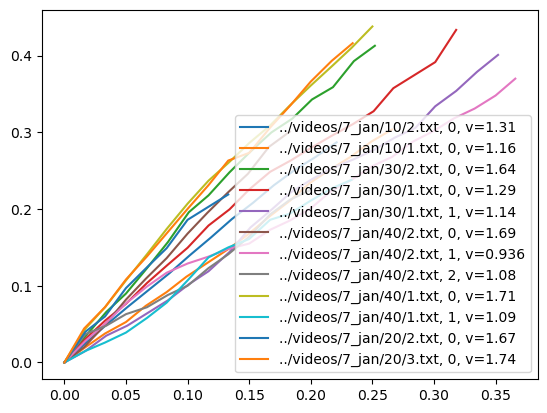

In [102]:
d = dict()

for p in glob.glob("../videos/7_jan/**/*.txt"):
    h = p.split("/")[-2]
    clusters = split_into_clusters(*load_track_txt(p))
    for i, (t, x) in enumerate(clusters):
        (   a, b), _ = curve_fit(lin_model, t, x)
        plt.plot(t-t[0], x-x[0], label=f"{p}, {i}, v={a:.3}")
        if i == 0:
            d[h] = d.get(h, []) + [a]

plt.legend()

In [113]:
hs = np.array(list(map(float, d.keys())))
vs_mean = np.array([ np.mean(d[i]) for i in d.keys()])
vs_std= np.array([ np.std(d[i]) for i in d.keys()])

In [122]:
vs_std

array([0.07479737, 0.17471805, 0.01047255, 0.03652256])

(0.0, 2.5)

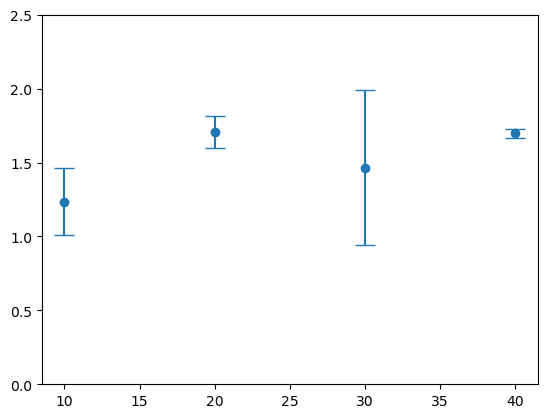

In [125]:
plt.errorbar(hs, vs_mean, yerr=3*vs_std, fmt='o',  capsize=7,)
plt.ylim(0, 2.5)

In [126]:
df_out = pd.DataFrame(columns=["height", "mean_velocity", "std_velocity"])
df_out["height"] = hs
df_out["mean_velocity"] = vs_mean
df_out["std_velocity"] = vs_std

In [128]:
df_out.to_csv("exp_height_vs_velocity.csv")